# Clustering data

We    are going to discuss in this notebook two different approaches to the problem of clustering data sets. We consider data sets of points, where each point is considered to be a $d-$ dimensional numeric vector in an euclidean space.
Given a data set, a cluster is a subset of points of the data set that are somehow related to each other. That is, they share some similar features, or we say that globally they form a group of related/similar points. For example, consider different demografic and economic variables for the countries. Do we observe a clear division between countries when  looking at those indicators ?

That we assume an euclidean space is at least necessary for our first approach, because the algorithm we use for it, the k-means algorithm, considers euclidean distances between points when measuring the Variance within each cluster produced. However, there are other variants of this algorithm that work with other distance metrics. So, if our original problem cannot be mapped, in a right way, to an euclidean space, then we shoudld consider the other variants. 

Both algorithms we show here are examples of **unsupervised learning** algorithms, they learn to what cluster belongs each data point without the prior knowledge of any *good* examples of points already well linked to their clusters. So, the algorithms work without practical clues about what points contain each cluster. In other words, they **discover** concepts without prior human assistance about how are the concepts they should find.

In [1]:
#
# Our preliminary set-up code
#

import pyspark
import os
import math
import random
import sys

%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt


spark_home = os.environ.get('SPARK_HOME', None)
sc = pyspark.SparkContext('local[*]')

print (spark_home, sc)

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


/usr/local/spark <pyspark.context.SparkContext object at 0x7f4ee04dbb38>


## Exact (crisp) clustering with Lloyd algorithm

We first consider the problem of *exact* clustering. We assume that there exist k clusters (groups of points), and that each point in our data set belongs to exactly one of the k clusters. We start assuming that we know the right number of clusters $k$, although this value is usually something we have to guess in real applications of clustering.

For presenting the algorithm, we need to introduce some notation first:

- Target set of data points: Target set of $n$-dimensional points $D=\{X_1,X_2,\ldots,X_m \}$

- Euclidean distance between two points: $ || x-y || = \sqrt{ \sum_{i = 1}^{n} (x_i-y_i)^2 } $  

- Centroid of a subset Y:  $  \frac{1}{|Y|} \sum_{y \in Y} y $ 

- Within-cluster sum of square errors (WCSSE) for a set of clusters C: 
$$ \sum_{c \in C} \sum_{x \in c} || x-center(c) ||^2 $$

Then, Lloyd algorithm considers that a cluster is defined simply by its center, and that the set of points that belong to a cluster is the set of points with smaller euclidean distance to that center than to any other cluster center. We can think about the cluster center as being the mean representative point of the cluster (although it can be the case that there is no single point in our data set that is exactly equal to that cluster center).
Then, Lloyd algorithm finds a set of k clusters with the following iterative WCSSE improving algorithm:

```python
clusters = Initial Guess for k clusters centers  
iters = 1  
while (clusters changed significantly  &   iters <= limit) do:  
  # Assign closest cluster to each point based on current cluster centers   
  for p in D:
      assign to p its nearest cluster center                    
  # Find best new set of cluster centers based on current centroids   
  For each c in k: 
      cluster(c) = centroid(points in D assigned to c)  
  iters = iters + 1 
```

From the two criterions to stop modifying the clusters, the first one refers to measuring the difference of the clusters between the previous iterations and the current one. We need to define what we mean by *changed significantly*, but usually that means that the distance between at least one pair (old_center_i,new_center_i), for some cluster i, is greater than certain threshold value. 

### Parallel implementation in the Map-Reduce framework

The k-means  algorithm we have just presented is a good example of an interesting algorithm to think about an efficient implementation in the Map-Reduce framework, and in the particular Spark programming framework where we can benefit from the memory-based, resilient distributed data sets that we can define from input data or from transformations of previous iterations.

First, regarding the data needed to store our current *model* for the clusters, observe that they are simply a set of k d-dimensional points (representing the centers of each cluster). So, assuming k is a small number compared with the total number of points in D (as it happens in typical applications of clustering), we are going to assume that the set of cluster centers can be mantained as shared information between all the workers in our spark application. 

Let's analyze how to implement the two steps performed in every iteration of Lloyd algorithm. 
- In the first step, we have to assign to each data point its closest cluster center, so in the next step we can group together all the points of each cluster to compute its centroid. This is clearly a map operation that can be performed locally with each point (provided we call a function where the set of cluster centers is packed with the function). A good way to format the ouput of such map function is to use (key,value) pairs, where the key is the cluster center and the value is a point assigned to that cluster center.

- In the second step, we have to compute the centroid of each set of points assigned to the same cluster center. So, in this case this is clearly a reduceByKey operation, where the reduce operation for two points assigned to the same cluster center is simply: p1+p2 (coordinate wise addition). Once we have all the points of every cluster added, we simply divide by the number of points of each cluster to get its centroid.

Consider the following data set of countries where we include the birth rate and death rate of every country in the data set. We will try to discover if there are any subgroups of countries, regarding their similarites in these two demographic indicators, using the k-means clustering algorithm

In [2]:
#
#  Coutry information about birth rate (2nd col) and death rate (3th col):
#
#  The complete countries data set can be found at: data/countries_data.csv
#
countriesdata = [ [ 'Afghanistan', 38.6, 13.9 ], \
                  [ 'Armenia',  13.6  ,  9.3 ], \
                  [ 'India',  19.6  ,  7.3 ], \
                  [ 'Iran', 18  ,  5.9 ], \
                  [ 'Iraq', 31.5  ,  3.8 ], \
                  [ 'Yemen', 30  ,  6.3 ], \
                  [ 'Israel', 18.5  ,  5.2 ], \
                  [ 'Italy',  8.7  ,  10.2  ], \
                  [ 'Germany'  ,  8.5  ,  11.4 ], \
                  [  'Denmark'  ,  10.3  ,  10.3    ], \
                  [  'France'  ,  12.4  ,  9.2    ], \
                  [  'Spain'  ,  9.6  ,  9     ], \
                  [ 'Austria'  ,  9.4  ,  9.4  ], \
                  [ 'Switzerland'  ,  10.5  ,  8.1 ], \
                  [  'Ecuador'  ,  18.5  ,  5.1 ], \
                  [  'Peru'  ,  18.3  ,  6 ], \
                  [  'Bolivia'  ,  22.8  ,  6.5 ], \
                  [  'Brazil'  ,  14.5  ,  6.6, ], \
                  [ 'Argentina'  ,  16.6  ,  7.3 ], \
                  [  'Chile'  ,  13.8  ,  6    ], \
                  [  'Colombia'  ,  16.5  ,  5.4 ] ]
                  

We are going to use the implementation of k-means available in spark, that incorporates an alternative way of creating the initial set of cluster centers (apart of the random method of picking uniformly at random k points to build the initial centers). But in this notebook we will not explore the alternative ways to create the initial centers, although they can have a big impact in the needed number of iterations to achieve good results. Check the paper:

> B. Bahmani, B. Moseley, A. Vattani, R. Kumar and S. Vassilvitskii. *Scalable K-Means++*. In Proceedings of PVLDB 5(7): 622-633. URL: http://theory.stanford.edu/~sergei/papers/vldb12-kmpar.pdf (2012)

If you want to know more about the specific alternative centers initialization available in the k-means implementation available in spark

In [4]:
#
#  Load specific packages for working with Kmeans clustering
#
# Full info about spark 1.6 k-means algorithm at:
#
#   http://spark.apache.org/docs/1.6.0/mllib-clustering.html#k-means

from pyspark.mllib.clustering import KMeans, KMeansModel

# Evaluate the error of a point, computed with its distance to the predicted cluster center
# (Within Cluster Sum of Squared Errors)
def error(clusters,point):
    center = clusters.centers[clusters.predict(point)]
    return sum([x**2 for x in (point - center)])

In [7]:
countriesRDD = sc.parallelize( countriesdata ).map( lambda p : np.array(p[1:]) )
countriesRDD.persist()

# Cluster the data in 3 clusters
countriesclusters1 = KMeans.train( countriesRDD, 3, maxIterations=20, \
                               initializationMode="random")



# Check the cluster assigned to each data point (user)
# If you execute several times the clustering algorithm, given
# the random initialization, the result obtained will be different
# in several executions.
# We could pick the one with smallest Error

#Show clusters centers:
for c in countriesclusters1.centers:
    print (c)

print ("")
cpredictions = {}
for country in countriesdata:
    cpredictions[country[0]] = countriesclusters1.predict(np.array(country[1:]))
    print ("Cluster for ", country[0], " : ", cpredictions[country[0]])

WCSSE = countriesRDD .map(lambda point: error(countriesclusters1,point)).reduce(lambda x, y: x + y)
print("Within Cluster Sum of Squared Error = " + str(WCSSE))
print("Average Square Error = "+ str(WCSSE/countriesRDD.count()))

[ 10.375    9.6125]
[ 33.36666667   8.        ]
[ 17.71   6.13]

Cluster for  Afghanistan  :  1
Cluster for  Armenia  :  0
Cluster for  India  :  2
Cluster for  Iran  :  2
Cluster for  Iraq  :  1
Cluster for  Yemen  :  1
Cluster for  Israel  :  2
Cluster for  Italy  :  0
Cluster for  Germany  :  0
Cluster for  Denmark  :  0
Cluster for  France  :  0
Cluster for  Spain  :  0
Cluster for  Austria  :  0
Cluster for  Switzerland  :  0
Cluster for  Ecuador  :  2
Cluster for  Peru  :  2
Cluster for  Bolivia  :  2
Cluster for  Brazil  :  2
Cluster for  Argentina  :  2
Cluster for  Chile  :  2
Cluster for  Colombia  :  2
Within Cluster Sum of Squared Error = 192.020416667
Average Square Error = 9.14382936508


If we execute k-means with the countries data set, almost all the executions obtain a model with WCSSE around 190, although some of them achieve a bigger error.

Because we have only two dimensions per point, we can easily plot the points of each cluster to visually inspect if the clusters learned make any sense. We can do this with a 2D plot that we make with matplotlib. 

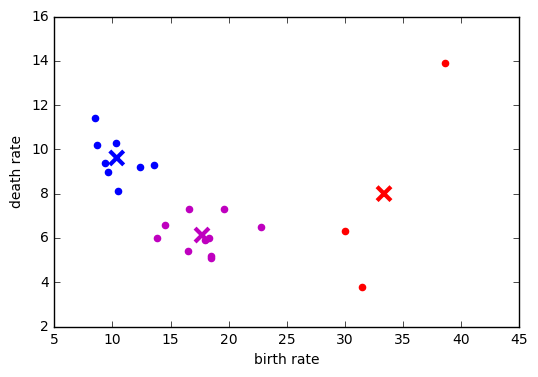

In [8]:
import itertools

palette = itertools.cycle(['b','r','m'])
for c in range(3):
  cclusterx = [ x[1] for x in countriesdata if cpredictions[x[0]] == c]               
  cclustery = [ x[2] for x in countriesdata if cpredictions[x[0]] == c]  
  plt.scatter(cclusterx,cclustery,color=next(palette) )
     

centersX = [ x[0] for x in countriesclusters1.centers ]
centersY = [ x[1] for x in countriesclusters1.centers ]
# Plot the center of each cluster
plt.scatter(centersX, centersY, marker='x', s=100, linewidths=3, color=['b','r','m'], zorder=10) 

plt.xlabel('birth rate')
plt.ylabel('death rate')
plt.show()    

Let's now turn our attention to the topic of discovering similar users for recommender systems. In particular, let's consider a data base of users, where for each user we store the ratings given by the user to different movies. We will talk more about recommender systems later in this course, dicussing more appropriate ways of dealing with such data, where tipically many entries (actually most of the entries) of such user-product matrix will be empty, so this clustering approach may not be always usable.

In [10]:
# Example data
#
# We have 10 users, and 10 movies: STW1, STW2, STW3, STW4, STW5, STW6
#                                  T1, T2, T3 and BaT
# Each entry i,j is the rating given by the user in the range [-5.0,5.0]
# We can observe that we have 4 clear Star Wars fans (that they also like a 
# little bit Terminator movies)
# We also have four clear Terminator fans (that they also like a little STWs movies)
# Finally, we have two clear Breakfast at tiffannies fans (BaT), that they do not
# like too much science-fiction movies

usersandmovies = [ [3,3,3,5,5,4, 3,3,-1, -1], \
                   [3,3,3,5,5,4, 4,2,0, -1], \
                   [3,3,4,5,5,4, 4,4,1, 0], \
                   [4,3,3,4,5,4, 3,3,1, -1], \
                   [1,1,1,0,1,1, 5,4,2, -1], \
                   [1,2,1,0,1,1, 4,4,2, -1], \
                   [1,2,2,1,1,1, 4,4,2, -1], \
                   [1,2,2,1,1,0, 5,4,3, -1], \
                   [-2,-3,-2,0,-2,-1, 0,0,-1,4], \
                   [-2,-3,-2,0,-2,-1, 0,0,-1,4]   ]

# An important issue, that we will not cover here, is what we do when there are 
# missing entries in a data set we want to cluster with an algorithm like
# k-means (for example, what we should put in the previous matrix for a movie j not seen
# by an user i ?). Take a look at this blog post if you want to explore a possible solution:
#
#  http://blog.supplyframe.com/2013/04/30/handling-missing-data-in-k-means/

The code we use for discovering three clusters in this second data set is almost identical to the previous one, given that the input data format is almost the same:

In [13]:
usersandmoviesRDD = sc.parallelize( usersandmovies ).map( lambda p : np.array(p) )
usersandmoviesRDD.persist()

# Cluster the data in 3 clusters
userclusters1 = KMeans.train( usersandmoviesRDD, 3, maxIterations=20, \
                               initializationMode="random")

# Check the cluster assigned to each data point (user)
# If you execute several times the clustering algorithm, given
# the random initialization, the result obtained will be different
# in several executions.
# We could pick the one with smallest Error

for user in usersandmovies:
    print ("Cluster for ", user, " : ", userclusters1.predict(np.array(user)))

WCSSE = usersandmoviesRDD.map(lambda point: error(userclusters1,point)).reduce(lambda x, y: x + y)
print("Within Cluster Sum of Squared Error = " + str(WCSSE))

Cluster for  [3, 3, 3, 5, 5, 4, 3, 3, -1, -1]  :  1
Cluster for  [3, 3, 3, 5, 5, 4, 4, 2, 0, -1]  :  1
Cluster for  [3, 3, 4, 5, 5, 4, 4, 4, 1, 0]  :  1
Cluster for  [4, 3, 3, 4, 5, 4, 3, 3, 1, -1]  :  1
Cluster for  [1, 1, 1, 0, 1, 1, 5, 4, 2, -1]  :  2
Cluster for  [1, 2, 1, 0, 1, 1, 4, 4, 2, -1]  :  2
Cluster for  [1, 2, 2, 1, 1, 1, 4, 4, 2, -1]  :  2
Cluster for  [1, 2, 2, 1, 1, 0, 5, 4, 3, -1]  :  2
Cluster for  [-2, -3, -2, 0, -2, -1, 0, 0, -1, 4]  :  0
Cluster for  [-2, -3, -2, 0, -2, -1, 0, 0, -1, 4]  :  0
Within Cluster Sum of Squared Error = 14.0


Observe that in *almost all* the executions of k-means with this data set, we discover the three subgroups of user profiles we have intentionally introduced in this data set of user movie reviews. However, in some executions the clusters discovered differ slightly, and the WCSSE increases from 14 to 35.

## Probabilistic (soft) clustering with Expectation Maximization

We are now going to tackle the problem of clustering data as assigning clusters to points following a probabilistic model. In this case, we assume that there is a probabilistic generative model with two components:
1. There is a probability distribution among the $k$ different clusters. This probability distribution dictates which cluster generates each point obtained from the source that generated our data set.
2. Once a cluster $i$ has been selected, the value for each dimension of the data point comes from a particular Multivariate gaussian distribution with particular mean ($d$-dimensional) vector $\mu_i$ and covariance ($d \times d$) matrix $\Sigma_i$.

This generation model is called a **k-Gaussian mixture model**. So, in this model we have two different sets of parameters: the probabilities that define the finite probability distribution among the $k$ clusters and the $\mu_i$ and $\Sigma_i$ parameters of the Multivariate gaussian distributions associated with the clusters. The conditional probability theorem tell us that the probability that a certain data point $\overline{x}$ is obtained in our data set can be expresed as:

$$ P(\overline{x} ) = \sum_i P(C=i) P( \overline{x} | C=i ) $$

where $ P(C=i) $ is the probability that the cluster that generated the data was $i$ and $   P( \overline{x} | C=i ) $ is the probability to obtain $\overline{x}$ with the multivariate gaussian distribution with parameters $\mu_i$ and  $\Sigma_i$. However, observe that in our clustering problem we do not know neither the cluster probabilities ($P(C=i)$) nor the gaussian parameters $\mu_i$ and  $\Sigma_i$ that allow us to compute $  P( \overline{x} | C=i ) $. So, the question is:

> Can we learn estimates of these $P(C=i)$ and  $\mu_i,\Sigma_i$ parameters from our data set ?

Observe that in our data set we do not have any attributes that indicate which clusters generated each data point. So even if we assume a model where the clusters are indicated by a certain random variable, that variable **is hidden** in our data (we cannot directly observe its value in our data points). The previous conditional probability equation gives us two possible ways to discover such parameters:

1. If we knew the $  P(C=i) $ parameters, we could learn the most likely values for the parameters  $\mu_i,\Sigma_i$ (the values for them that maximize the probabilities observed for our data points).

2. If we knew the  $\mu_i,\Sigma_i$ parameters, we could learn the most likely values for the cluster probabilities  $  P(C=i)$.

So, how can we break this deadlock situation ?

### The EM algorithm for learning a k-Gaussian mixture model

Given the mutual dependence between the two sets of parameters we want to learn, the approach to learn a good estimation of them is to use an iterative algorithm that although it may not always learn the best possible model, in many cases learns a good enough model (one that predicts with good accuracy the probabilities of the observed data points). This algorithm is the Expectation Maximization algorithm for a k-Gaussian mixture model. As we are going to see, this algorithm actually behaves like a probabilistic version of the previous k-means algorithm, where instead of assigning an unique cluster to each point, we define a probability distribution over cluster selection and  $\mu_i,\Sigma_i$  parameters for each cluster that change in every iteration until no further changes to the parameters can give a better fit to the probabilites observed. But with this  k-Gaussian mixture model, a point is never crisply assigned to a cluster, although the algorithm computes the probability that a particular cluster generated one of our data points. The EM algorithm for  learning a k-Gaussian mixture model is the following one:

Initially, we generate random/pseudo-random values (or with some other method) for the parameters $  P(C=i) $ and $\mu_i,\Sigma_i$ .

Then, we change the parameters iteratively **until they converge** repeating the two following steps:  
1. In the E-step, we compute the expected values for the hidden indicator random variables that indicate which cluster generated each data point, given the current model parameters. That is, the expected values for probabilities $ P(C=i| \overline{x} )  $. By bayes conditional probability rule these probabilities can be computed using our initial equation and current model parameters as:
$$ P(C=i| \overline{x} ) = \frac{   P(C=i) P( \overline{x} | C=i ) }{\sum_j P(C=j) P( \overline{x} | C=j ) } $$  
Observe that $P(C=i)$ and $ P( \overline{x} | C=i ) $ are computed with our current model parameters, as $ P( \overline{x} | C=i ) $ is computed with the probability density function of a multivariate normal distribution with parameters  $\mu_i,\Sigma_i$. Check https://en.wikipedia.org/wiki/Multivariate_normal_distribution#Density_function
  
2. In the M-step, we compute new parameter values for  $  P(C=i) $ and $\mu_i,\Sigma_i$ that maximize the likelihood of our data points, given the expected values $ P(C=i| \overline{x} ) $ for the hidden variables  computed in the previous step:
$$ \mu_i = \frac{1}{p_i} \sum_{\overline{x}} \overline{x}   P(C=i| \overline{x} )  $$ 
$$ \Sigma_i = \frac{1}{p_i} \sum_{\overline{x}}
  P(C=i| \overline{x} ) (\overline{x}-\mu_i)(\overline{x}-\mu_i)^T $$  
$$ P(C=i) = p_i / N  $$ 

where $p_i = \sum_{\overline{x}} P(C=i| \overline{x} )$  and $N$ is the number of data points in the data set.


###  Parallel implementation in the Map-Reduce framework

The implementation in a Map-Reduce framework of this algorithm follows a similar scheme to the one described for the k-means algorithm, as both algorithms perform a similar work inside of the two steps they execute in every iteration:

1. In the E-step, for each point $\overline{x}$ we have to compute the probabilites $ P(C=i| \overline{x} )  $ associated with the hidden variable. This computation is local to each data point (for each point $\overline{x}$  we compute its set of k $ P(C=i| \overline{x} )  $ values using only the current parameters of the model. So, this step is totally independent for each data point, and thus it can be implemented as a pure Map operation. Observe the analogy with k-means: in k-means, in the first step we compute the most probable cluster for each point, here we compute a probability distribution over clusters for each point.
2. In the M-step, for each cluster $i$ we compute new parameters  $  P(C=i) $ and $\mu_i,\Sigma_i$ collecting the values $ P(C=i| \overline{x} )  $ computed for all the points $ \overline{x}$. First, we can compute $\mu_i$ using a Map-Reduce operation (with all the $  \overline{x} P(C=i| \overline{x} )  $ values), and then $ \Sigma_i$ is  computed with a second Map-Reduce operation, with Map we compute the $d \times d$ matrix $ (\overline{x}-\mu_i)(\overline{x}-\mu_i)^T $ for each point and cluster $i$, and then all such matrices with the same $i$ value are summed up in a Reduce operation to finally compute $\Sigma_i$. Compare this with k-means: in k-means, in the second step we combined all the points of a same cluster i to compute the new centers of the clusters.


Then, once the algorithm converges (so no better parameters can be found), we end up with a model that although is locally good, it may not necessarilly be the best global model. That is, better models could be found if we were changing at the same time both the hidden variables distributions and the clusters parameters. But there is no good method to perform such global search through the space of all parameter combinations. 
With the resulting model, observe that we can use the final parameters $  P(C=i| \overline{x} )  $ to make a soft prediction of the cluster that generated each data point $\overline{x}$.

For a more detailed discussion of the implementation of the distributed version of this algorithm in different distributed frameworks, read the paper:
> H. Cui, J. Wei and W Dai. *Parallel Implementation of Expectation-Maximization for Fast Convergence*. URL: https://users.ece.cmu.edu/~hengganc/archive/report/final.pdf

It is worth noticing that EM based algorithms are also used for predicting values of other families of random variables in problems where we assume that our data has been generated (or can be modelled) with certain random variables where some of their parameters are unkown, but we want to learn the most probable parameters for those random variables given our data. As an another example of the use of EM based algorithms for big data applications, check for example the following paper:

> Timothy Hunter, Teodor Mihai Moldovan, Matei Zaharia, Samy Merzgui, Justin Ma, Michael J. Franklin, Pieter Abbeel, Alexandre M. Bayen: Scaling the mobile millennium system in the cloud. SoCC 2011: 28
URL: https://cs.stanford.edu/~matei/papers/2011/socc_mobile_millennium.pdf

In [14]:
#
#  Load specific packages for working with Gaussian-Mixture clustering
#
#  More info at:
#   http://spark.apache.org/docs/1.6.0/mllib-clustering.html#gaussian-mixture

from pyspark.mllib.clustering import GaussianMixture


We are going to test the learning of a k-Gaussian mixture model with an implementation of the EM algorithm available in spark. Let's try it first with our data set of countries.

In [15]:
countriesRDD = sc.parallelize( countriesdata ).map( lambda p : np.array(p[1:]) )
countriesRDD.persist()

# Learn a 3-Gaussian mixture model with EM algorithm with 20 as the maximum
# number of iterations, but stop before if convergence is reached.
# Remember that each iteration executes different Map-reduce operations
# so, the less iterations the less 
gmc = GaussianMixture.train( countriesRDD , 3, maxIterations=20)

# Show probability distribution over clusters for each point,
# the probability that a certain cluster generated one of our points
# (soft prediction)
# This can be turned to a crisp prediction if we select for the cluster
# of the data point the most probable cluster
# We can also make the soft prediction for all the whole RDD with:
bestcclustersRDD = gmc.predictSoft(countriesRDD)

i = 0
for countrypred in bestcclustersRDD.collect():
    print ( countriesdata[i][0], " soft: ",countrypred , \
    " most probable: ", countrypred.index(max(countrypred)))
    i = i + 1

print ("\n")

# output parameters of model
#
#  weights[i] = probability of selecting cluster i in k-Gaussian mixture model
#  gmc.gaussians[i].mu = mean vector for i cluster
#  gmc.gaussians[i].sigma.toArray() = covariance matrix for i cluster
for i in range(3):
    print ("weight = ", gmc.weights[i], "mu = ", gmc.gaussians[i].mu,
        "sigma = ", gmc.gaussians[i].sigma.toArray())
    

Afghanistan  soft:  array('d', [1.0, 7.051187845292559e-19, 7.051187845292559e-19])  most probable:  0
Armenia  soft:  array('d', [4.91345524134259e-15, 0.8939218142606888, 0.10607818573930626])  most probable:  1
India  soft:  array('d', [1.7967258440500964e-14, 0.9916321272022548, 0.00836787279772732])  most probable:  1
Iran  soft:  array('d', [1.3300629162566005e-14, 1.3300629162566005e-14, 0.9999999999999734])  most probable:  2
Iraq  soft:  array('d', [1.0570881106867672e-14, 0.9999999999974185, 2.5708606099069032e-12])  most probable:  1
Yemen  soft:  array('d', [1.0, 7.051187845291895e-19, 7.057115751982228e-19])  most probable:  0
Israel  soft:  array('d', [1.4137560418520932e-14, 1.4137560418520932e-14, 0.9999999999999717])  most probable:  2
Italy  soft:  array('d', [1.6380994226824038e-14, 1.7069326595499638e-14, 0.9999999999999666])  most probable:  2
Germany  soft:  array('d', [5.841111247463616e-14, 5.885378858878423e-14, 0.9999999999998828])  most probable:  2
Denmark  

###  Exercises

Can you make a program that compares the set clusters predicted with both clustering algorithms (k-means and EM for k-Gaussian mixture) ? 

Can you adapt the previous matplotlib code to plot the clusters obtained with the EM algorithm (assuming we assign to each point the most probable cluster) ?

Consider clustering all the countries in the file countries_data.csv but using also the variables Population, life expectancy and GDP (this last one found in the file countries_GDP.csv)  

### The user-movies data set

Next, let's check the probabilistic model obtained with our users and movies data set

In [19]:
# Build the model (cluster the data) with expectation maximization
# for our usersandmovies data set
gmm = GaussianMixture.train( usersandmoviesRDD, 3, maxIterations=20)

# Let's show the soft prediction for each data point
bestclustersRDD = gmm.predictSoft(usersandmoviesRDD)
for user in bestclustersRDD.collect():
    print (user,\
    " most probable: ", user.index(max(user)))

print ("\n")


array('d', [1.0, 8.298324962378164e-42, 8.298324962378164e-42])  most probable:  0
array('d', [1.0, 8.298324962378164e-42, 8.298324962378164e-42])  most probable:  0
array('d', [1.0, 8.298324962378045e-42, 8.298324962378045e-42])  most probable:  0
array('d', [1.0, 8.298324962377987e-42, 8.298324962422972e-42])  most probable:  0
array('d', [4.815055708594409e-12, 4.815055708594409e-12, 0.9999999999903699])  most probable:  2
array('d', [4.815055708594426e-12, 4.815055708594426e-12, 0.9999999999903699])  most probable:  2
array('d', [4.815055708594409e-12, 4.815055708594409e-12, 0.9999999999903699])  most probable:  2
array('d', [4.8150557085944e-12, 4.8150557085944e-12, 0.9999999999903699])  most probable:  2
array('d', [1.0771127486461517e-48, 1.0, 4.587066399685257e-44])  most probable:  1
array('d', [1.0771127486461517e-48, 1.0, 4.587066399685257e-44])  most probable:  1




As you can see, picking the most probable cluster for each data point we obtain **in many executions** the same user clusters we obtained with the most typical executions of k-means. However, observe that the probability distributions obtained over the three clusters give us more information, as they can be used to measure how similar may be two particular clusters, when considered as possible clusters for a data point.